##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hello, many worlds

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/hello_many_worlds"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/hello_many_worlds.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/hello_many_worlds.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/hello_many_worlds.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how a classical neural network can learn to correct qubit calibration errors. It introduces <a target="_blank" href="https://github.com/quantumlib/Cirq" class="external">Cirq</a>, a Python framework to create, edit, and invoke Noisy Intermediate Scale Quantum (NISQ) circuits, and demonstrates how Cirq interfaces with TensorFlow Quantum.

## Setup

In [2]:
!pip install -q tensorflow==2.3.1

Install TensorFlow Quantum:

In [3]:
!pip install -q tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. The Basics

### 1.1 Cirq and parameterized quantum circuits

Before exploring TensorFlow Quantum (TFQ), let's look at some <a target="_blank" href="https://github.com/quantumlib/Cirq" class="external">Cirq</a> basics. Cirq is a Python library for quantum computing from Google. You use it to define circuits, including static and parameterized gates.

Cirq uses <a target="_blank" href="https://www.sympy.org" class="external">SymPy</a> symbols to represent free parameters.

In [5]:
a, b = sympy.symbols('θ ϕ')

The following code creates a two-qubit circuit using your parameters:

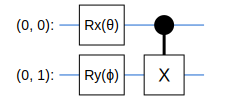

In [7]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

To evaluate circuits, you can use the `cirq.Simulator` interface. You replace free parameters in a circuit with specific numbers by passing in a `cirq.ParamResolver` object. The following code calculates the raw state vector output of your parameterized circuit:

In [8]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

State vectors are not directly accessible outside of simulation (notice the complex numbers in the output above). To be physically realistic, you must specify a measurement, which converts a state vector into a real number that classical computers can understand. Cirq specifies measurements using combinations of the <a target="_blank" href="https://en.wikipedia.org/wiki/Pauli_matrices" class="external">Pauli operators</a> $\hat{X}$, $\hat{Y}$, and $\hat{Z}$. As illustration, the following code measures $\hat{Z}_0$ and $\frac{1}{2}\hat{Z}_0 + \hat{X}_1$ on the state vector you just simulated:

In [11]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [12]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

### 1.2 Quantum circuits as tensors

TensorFlow Quantum (TFQ) provides `tfq.convert_to_tensor`, a function that converts Cirq objects into tensors. This allows you to send Cirq objects to our <a target="_blank" href="https://www.tensorflow.org/quantum/api_docs/python/tfq/layers">quantum layers</a> and <a target="_blank" href="https://www.tensorflow.org/quantum/api_docs/python/tfq/get_expectation_op">quantum ops</a>. The function can be called on lists or arrays of Cirq Circuits and Cirq Paulis:

In [13]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


This encodes the Cirq objects as `tf.string` tensors that `tfq` operations decode as needed.

In [14]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

### 1.3 Batching circuit simulation

TFQ provides methods for computing expectation values, samples, and state vectors. For now, let's focus on *expectation values*.

The highest-level interface for calculating expectation values is the `tfq.layers.Expectation` layer, which is a `tf.keras.Layer`. In its simplest form, this layer is equivalent to simulating a parameterized circuit over many `cirq.ParamResolvers`; however, TFQ allows batching following TensorFlow semantics, and circuits are simulated using efficient C++ code.

Create a batch of values to substitute for our `a` and `b` parameters:

In [12]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

Batching circuit execution over parameter values in Cirq requires a loop:

In [13]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[-0.05406404]
 [-0.9398433 ]
 [ 0.00876793]
 [-0.38218546]
 [-0.86020774]]


The same operation is simplified in TFQ:

In [14]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.05406457],
       [-0.9398428 ],
       [ 0.0087699 ],
       [-0.38218608],
       [-0.86020815]], dtype=float32)>

## 2. Hybrid quantum-classical optimization

Now that you've seen the basics, let's use TensorFlow Quantum to construct a *hybrid quantum-classical neural net*. You will train a classical neural net to control a single qubit. The control will be optimized to correctly prepare the qubit in the `0` or `1` state, overcoming a simulated systematic calibration error. This figure shows the architecture:

<img src="./images/nn_control1.png" width="1000">

Even without a neural network this is a straightforward problem to solve, but the theme is similar to the real quantum control problems you might solve using TFQ. It demonstrates an end-to-end example of a quantum-classical computation using the `tfq.layers.ControlledPQC` (Parametrized Quantum Circuit) layer inside of a `tf.keras.Model`.

For the implementation of this tutorial, this is architecture is split into 3 parts:

- The *input circuit* or *datapoint circuit*: The first three $R$ gates.
- The *controlled circuit*: The other three $R$ gates.
- The *controller*: The classical neural-network setting the parameters of the controlled circuit.

### 2.1 The controlled circuit definition

Define a learnable single bit rotation, as indicated in the figure above. This will correspond to our controlled circuit.

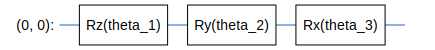

In [15]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

### 2.2 The controller

Now define controller network: 

In [16]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

Given a batch of commands, the controller outputs a batch of control signals for the controlled circuit. 

The controller is randomly initialized so these outputs are not useful, yet.

In [17]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[0.        , 0.        , 0.        ],
       [0.9778063 , 0.05454256, 0.74746895]], dtype=float32)

### 2.3 Connect the controller to the circuit

Use `tfq` to connect the controller to the controlled circuit, as a single `keras.Model`. 

See the [Keras Functional API guide](https://www.tensorflow.org/guide/keras/functional) for more about this style of model definition.

First define the inputs to the model:  

In [18]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')


Next apply operations to those inputs, to define the computation.

In [19]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

Now package this computation as a `tf.keras.Model`:

In [20]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

The network architecture is indicated by the plot of the model below.
Compare this model plot to the architecture diagram to verify correctness.

Note: May require a system install of the `graphviz` package.

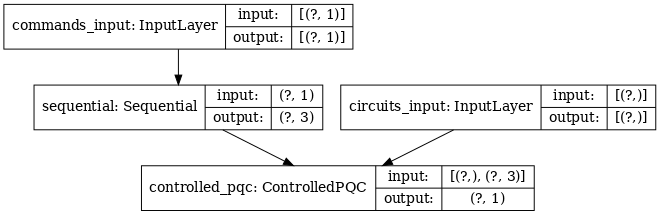

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

This model takes two inputs: The commands for the controller, and the input-circuit whose output the controller is attempting to correct. 

### 2.4 The dataset

The model attempts to output the correct correct measurement value of $\hat{Z}$ for each command. The commands and correct values are defined below.

In [22]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

This is not the entire training dataset for this task. 
Each datapoint in the dataset also needs an input circuit.

### 2.4 Input circuit definition

The input-circuit below defines the random miscalibration the model will learn to correct.

In [23]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

There are two copies of the circuit, one for each datapoint.

In [24]:
datapoint_circuits.shape

TensorShape([2])

### 2.5 Training

With the inputs defined you can test-run the `tfq` model.

In [25]:
model([datapoint_circuits, commands]).numpy()

array([[0.1511403],
       [0.7635183]], dtype=float32)

Now run a standard training process to adjust these values towards the `expected_outputs`.

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

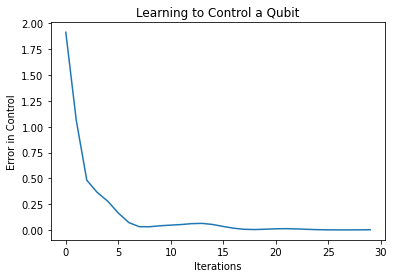

In [27]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

From this plot you can see that the neural network has learned to overcome the systematic miscalibration.

### 2.6 Verify outputs
Now use the trained model, to correct the qubit calibration errors. With Cirq:

In [28]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expectation = z0.expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-0.3176997  -1.4475782   0.46939707]
Which gives an actual expectation of: 0.9934208989143372

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [ 0.23679024 -2.5259602  -1.7193915 ]
Which gives an actual expectation of: -0.9035686254501343



The value of the loss function during training provides a rough idea of how well the model is learning. The lower the loss, the closer the expectation values in the above cell is to `desired_values`. If you aren't as concerned with the parameter values, you can always check the outputs from above using `tfq`:

In [29]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.99342084],
       [-0.9035689 ]], dtype=float32)>

## 3 Learning to prepare eigenstates of different operators

The choice of the $\pm \hat{Z}$ eigenstates corresponding to 1 and 0 was arbitrary. You could have just as easily wanted 1 to correspond to the $+ \hat{Z}$ eigenstate and 0 to correspond to the $-\hat{X}$ eigenstate. One way to accomplish this is by specifying a different measurement operator for each command, as indicated in the figure below:

<img src="./images/nn_control2.png" width="1000">

This requires use of <code>tfq.layers.Expectation</code>. Now your input has grown to include three objects: circuit, command, and operator. The output is still the expectation value.

### 3.1 New model definition

Lets take a look at the model to accomplish this task:

In [30]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

Here is the controller network:

In [31]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

Combine the circuit and the controller into a single `keras.Model` using `tfq`:

In [32]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

### 3.2 The dataset

Now you will also include the operators you wish to measure for each datapoint you supply for `model_circuit`:

In [33]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

### 3.3 Training

Now that you have your new inputs and outputs you can train once again using keras.

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Epoch 1/30
1/1 [==============================] - 0s 1ms/step - loss: 0.3780
Epoch 2/30
1/1 [==============================] - 0s 749us/step - loss: 0.0991
Epoch 3/30
1/1 [==============================] - 0s 722us/step - loss: 0.0372
Epoch 4/30
1/1 [==============================] - 0s 688us/step - loss: 0.0172
Epoch 5/30
1/1 [==============================] - 0s 602us/step - loss: 0.0112
Epoch 6/30
1/1 [==============================] - 0s 687us/step - loss: 0.0217
Epoch 7/30
1/1 [==============================] - 0s 832us/step - loss: 0.0267
Epoch 8/30
1/1 [==============================] - 0s 628us/step - loss: 0.0162
Epoch 9/30
1/1 [==============================] - 0s 651us/step - loss: 0.0056
Epoch 10/30
1/1 [==============================] - 0s 647us/step - loss: 0.0014
Epoch 11/30
1/1 [==============================] - 0s 773us/step - loss: 5.7171e-04
Epoch 12/30
1/1 [==============================] - 0s 642us/step - loss: 9.3358e-04
Epoch 13/30
1/1 [==========================

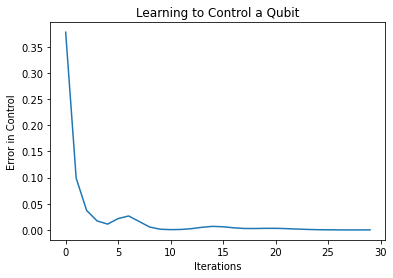

In [35]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

The loss function has dropped to zero.

The `controller` is available as a stand-alone model. Call the controller, and check its response to each command signal. It would take some work to correctly compare these outputs to the contents of `random_rotations`.

In [36]:
controller.predict(np.array([0,1]))

array([[-0.8924351 ,  0.20870398, -0.3417979 ],
       [ 1.338636  ,  1.5487468 , -2.335971  ]], dtype=float32)

Success: See if you can adapt the `check_error` function from your first model to work with this new model architecture.